## Imports

In [23]:
import os
import json
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import csv
import time

#from core.data_processor_train_test import DataLoader
#from core.model_train_test import Model
from core.talib2 import TaLib
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, MaxAbsScaler, Normalizer, QuantileTransformer
from sklearn.preprocessing import LabelEncoder
from datetime import datetime


## Carregar os Dados e Gerar os Indicadores Técnicos

In [24]:
# Carregando as configurações do arquivo 'config_modelo.json'
configs = json.load(open('config_modelo.json', 'r'))

In [25]:
# Criar a pasta 'save_dir' caso não exista no diretório
if not os.path.exists(configs['model']['save_dir']):
            os.makedirs(configs['model']['save_dir'])

In [26]:
# Carregar o Dataset
datapath = os.path.join('dataset', configs['dataset']['filename'])
data = pd.read_csv(datapath)
data.columns.array

<PandasArray>
[  'DATE',   'TIME',   'OPEN',   'HIGH',    'LOW',  'CLOSE',    'VOL',
   'vwap',  'sma20',  'sma60',  'sma80', 'sma200', 'sma400', 'sma600']
Length: 14, dtype: object

In [27]:
# Selecionar apenas as colunas com OHLCV
data_ohlcv = data.drop(['vwap',  'sma20',  'sma60',  'sma80', 'sma200', 'sma400', 'sma600'], axis=1)
print(data_ohlcv.shape)
data_ohlcv.head(1)

(139904, 7)


,DATE,TIME,OPEN,HIGH,LOW,CLOSE,VOL
0,2014.11.19,10:50:00,53010,53175,53000,53155,4099


In [28]:
# Verificando se existem dados faltantes
data_ohlcv.isnull().sum()

DATE     0
TIME     0
OPEN     0
HIGH     0
LOW      0
CLOSE    0
VOL      0
dtype: int64

In [29]:
# Carregando cada coluna do dataframe em vetores 
input_candlesticks = {
                        'date': np.array(data_ohlcv['DATE'].astype(str)),
                        'time': np.array(data_ohlcv['TIME'].astype(str)),
                        'open': np.array(data_ohlcv['OPEN'].astype(float)),
                        'high': np.array(data_ohlcv['HIGH'].astype(float)),
                        'low': np.array(data_ohlcv['LOW'].astype(float)),
                        'close': np.array(data_ohlcv['CLOSE'].astype(float)),
                        'volume': np.array(data_ohlcv['VOL'].astype(float))
                    }
 # Gerar os TIs através do TaLib
indicadores = TaLib(input_candlesticks)
indicadores_DB = indicadores.lista_de_indicadores()
print(indicadores_DB.shape)
indicadores_DB.head(2)

(139904, 126)


,DATE,TIME,OPEN,HIGH,LOW,CLOSE,VOL,BBANDS_Upper_5,BBANDS_Lower_5,BBANDS_Upper_10,...,WILLR_12,WILLR_20,AD,ADOSC,OBV,ATR_3,ATR_6,ATR_12,ATR_20,TRANGE
0,2014.11.19,10:50:00,53010.0,53175.0,53000.0,53155.0,4099.0,NaN,NaN,NaN,...,NaN,NaN,3162.085714,NaN,4099.0,NaN,NaN,NaN,NaN,NaN
1,2014.11.19,10:55:00,53150.0,53230.0,53130.0,53165.0,3745.0,NaN,NaN,NaN,...,NaN,NaN,2038.585714,NaN,7844.0,NaN,NaN,NaN,NaN,100.0


In [30]:
# Verificando se existem dados faltantes
indicadores_DB.isnull().sum()

DATE       0
TIME       0
OPEN       0
HIGH       0
LOW        0
          ..
ATR_3      3
ATR_6      6
ATR_12    12
ATR_20    20
TRANGE     1
Length: 126, dtype: int64

In [31]:
# Apagando linhas com dados NaN
indicadores_DB.dropna(axis=0, inplace=True)
print(indicadores_DB.shape)
indicadores_DB.head(2)

(139884, 126)


,DATE,TIME,OPEN,HIGH,LOW,CLOSE,VOL,BBANDS_Upper_5,BBANDS_Lower_5,BBANDS_Upper_10,...,WILLR_12,WILLR_20,AD,ADOSC,OBV,ATR_3,ATR_6,ATR_12,ATR_20,TRANGE
20,2014.11.19,12:30:00,53560.0,53565.0,53405.0,53410.0,8363.0,53752.526189,53227.473811,53701.563032,...,-50.000000,-50.000000,-78.077776,224.882410,16995.0,183.08836,157.567344,133.163314,122.7500,160.0
21,2014.11.19,12:35:00,53410.0,53500.0,53295.0,53415.0,7034.0,53712.281525,53317.718475,53699.874976,...,-49.324324,-49.324324,1122.849053,-968.557883,24029.0,190.39224,165.472787,139.149704,126.8625,205.0


In [32]:
# Concatenar colunas 'DATE' e 'TIME' e converter para DateTime
indicadores_DB['DATETIME'] = indicadores_DB[['DATE', 'TIME']].agg(' '.join, axis=1)
# indicadores_DB.drop(['DATE', 'TIME'], axis=1,inplace=True)
indicadores_DB['DATETIME'] = pd.to_datetime(indicadores_DB['DATETIME'])

col = indicadores_DB.pop("DATETIME")
indicadores_DB.insert(0, col.name, col)
print(indicadores_DB.shape)
indicadores_DB.head(2)

(139884, 127)


,DATETIME,DATE,TIME,OPEN,HIGH,LOW,CLOSE,VOL,BBANDS_Upper_5,BBANDS_Lower_5,...,WILLR_12,WILLR_20,AD,ADOSC,OBV,ATR_3,ATR_6,ATR_12,ATR_20,TRANGE
20,2014-11-19 12:30:00,2014.11.19,12:30:00,53560.0,53565.0,53405.0,53410.0,8363.0,53752.526189,53227.473811,...,-50.000000,-50.000000,-78.077776,224.882410,16995.0,183.08836,157.567344,133.163314,122.7500,160.0
21,2014-11-19 12:35:00,2014.11.19,12:35:00,53410.0,53500.0,53295.0,53415.0,7034.0,53712.281525,53317.718475,...,-49.324324,-49.324324,1122.849053,-968.557883,24029.0,190.39224,165.472787,139.149704,126.8625,205.0


In [33]:
# Ajustar o index do DataFrame
indicadores_DB = indicadores_DB.reset_index()
indicadores_DB.drop('index', axis=1, inplace=True)
print(indicadores_DB.shape)
indicadores_DB.head(2)

(139884, 127)


,DATETIME,DATE,TIME,OPEN,HIGH,LOW,CLOSE,VOL,BBANDS_Upper_5,BBANDS_Lower_5,...,WILLR_12,WILLR_20,AD,ADOSC,OBV,ATR_3,ATR_6,ATR_12,ATR_20,TRANGE
0,2014-11-19 12:30:00,2014.11.19,12:30:00,53560.0,53565.0,53405.0,53410.0,8363.0,53752.526189,53227.473811,...,-50.000000,-50.000000,-78.077776,224.882410,16995.0,183.08836,157.567344,133.163314,122.7500,160.0
1,2014-11-19 12:35:00,2014.11.19,12:35:00,53410.0,53500.0,53295.0,53415.0,7034.0,53712.281525,53317.718475,...,-49.324324,-49.324324,1122.849053,-968.557883,24029.0,190.39224,165.472787,139.149704,126.8625,205.0


### Criação de Novas Features

In [34]:
indicadores_DB['MES'] = indicadores_DB['DATETIME'].dt.month
indicadores_DB['DIA_SEMANA'] = indicadores_DB['DATETIME'].dt.weekday

def define_period(num):
    #print(type(num))
    if num.hour <= 11:
        if num.hour < 10:
            if (num.minute < 30):
                return '0'
        return '1'
    elif num.hour < 16:
        return '2'
    else:
        return '3'

indicadores_DB['HORA_NOBRE'] = indicadores_DB['DATETIME'].map(define_period)
print(indicadores_DB.shape)


(139884, 130)


In [35]:
indicadores_DB.iloc[60:80, :]

,DATETIME,DATE,TIME,OPEN,HIGH,LOW,CLOSE,VOL,BBANDS_Upper_5,BBANDS_Lower_5,...,ADOSC,OBV,ATR_3,ATR_6,ATR_12,ATR_20,TRANGE,MES,DIA_SEMANA,HORA_NOBRE
60,2014-11-19 17:30:00,2014.11.19,17:30:00,54040.0,54060.0,53935.0,53945.0,3612.0,54143.907194,53756.092806,...,5435.387475,27250.0,140.177153,153.433124,150.601069,143.899774,125.0,11,2,3
61,2014-11-19 17:35:00,2014.11.19,17:35:00,53940.0,53950.0,53800.0,53820.0,3785.0,54127.716139,53786.283861,...,3111.078426,23465.0,143.451435,152.860937,150.550980,144.204786,150.0,11,2,3
62,2014-11-19 17:40:00,2014.11.19,17:40:00,53820.0,53890.0,53785.0,53835.0,4255.0,54136.322072,53741.677928,...,1818.265817,27720.0,130.634290,144.884114,146.755065,142.244546,105.0,11,2,3
63,2014-11-19 17:45:00,2014.11.19,17:45:00,53840.0,53880.0,53820.0,53850.0,1914.0,54064.685332,53731.314668,...,1131.440036,29634.0,107.089527,130.736762,139.525476,138.132319,60.0,11,2,3
64,2014-11-19 17:50:00,2014.11.19,17:50:00,53850.0,53900.0,53750.0,53810.0,3147.0,53948.871048,53755.128952,...,535.956817,26487.0,121.393018,133.947301,140.398353,138.725703,150.0,11,2,3
65,2014-11-19 18:01:01,2014.11.19,18:01:01,53820.0,53820.0,53820.0,53820.0,1521.0,53855.000000,53799.000000,...,242.794162,28008.0,84.262012,113.289418,129.531824,132.289418,10.0,11,2,3
66,2014-11-21 09:00:00,2014.11.21,09:00:00,54400.0,54500.0,54280.0,54440.0,2960.0,54440.750957,53461.249043,...,565.821600,30968.0,282.841341,207.741182,175.404172,159.674947,680.0,11,4,0
67,2014-11-21 09:05:00,2014.11.21,09:05:00,54465.0,54585.0,54445.0,54505.0,2600.0,54719.665266,53450.334734,...,530.390887,33568.0,236.894228,197.284318,172.870491,158.941200,145.0,11,4,0
68,2014-11-21 09:10:00,2014.11.21,09:10:00,54490.0,54545.0,54420.0,54535.0,1423.0,54889.490824,53554.509176,...,888.366287,34991.0,199.596152,185.236932,168.881283,157.244140,125.0,11,4,0
69,2014-11-21 09:15:00,2014.11.21,09:15:00,54540.0,54625.0,54500.0,54595.0,2530.0,54946.852093,53811.147907,...,1426.881549,37521.0,174.730768,175.197443,165.224510,155.631933,125.0,11,4,0


In [36]:
indicadores_DB[['DATETIME', 'HORA_NOBRE']].iloc[60:80, :]

,DATETIME,HORA_NOBRE
60,2014-11-19 17:30:00,3
61,2014-11-19 17:35:00,3
62,2014-11-19 17:40:00,3
63,2014-11-19 17:45:00,3
64,2014-11-19 17:50:00,3
65,2014-11-19 18:01:01,3
66,2014-11-21 09:00:00,0
67,2014-11-21 09:05:00,0
68,2014-11-21 09:10:00,0
69,2014-11-21 09:15:00,0


<AxesSubplot:xlabel='DATETIME'>

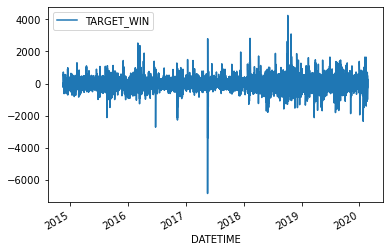

In [37]:
# Criando a coluna Target com diff(horizonte de previsão)
horizon = configs['dataset']['horizon']
indicadores_DB['TARGET_WIN'] = indicadores_DB['CLOSE'].diff(periods=horizon).shift(-horizon)
indicadores_DB.plot(x='DATETIME', y='TARGET_WIN')

In [38]:
indicadores_DB['TARGET_WIN'].describe()

count    139881.000000
mean          1.297817
std         170.642595
min       -6855.000000
25%         -75.000000
50%           0.000000
75%          75.000000
max        4245.000000
Name: TARGET_WIN, dtype: float64

In [39]:
indicadores_DB.groupby(['HORA_NOBRE'])['TARGET_WIN'].describe()

,count,mean,std,min,25%,50%,75%,max
HORA_NOBRE,,,,,,,,
0,7742.0,1.803797,140.271911,-1485.0,-65.0,5.0,70.0,1030.0
1,38759.0,-0.659718,169.577108,-3400.0,-90.0,0.0,90.0,2795.0
2,62229.0,-0.796976,129.680303,-1570.0,-70.0,0.0,70.0,1315.0
3,31151.0,7.792366,237.568781,-6855.0,-70.0,5.0,75.0,4245.0


<AxesSubplot:>

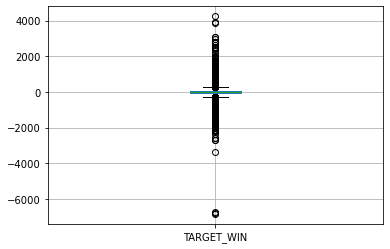

In [40]:
indicadores_DB.boxplot('TARGET_WIN')

In [41]:
indicadores_DB.query('TARGET_WIN < -6000')

,DATETIME,DATE,TIME,OPEN,HIGH,LOW,CLOSE,VOL,BBANDS_Upper_5,BBANDS_Lower_5,...,OBV,ATR_3,ATR_6,ATR_12,ATR_20,TRANGE,MES,DIA_SEMANA,HORA_NOBRE,TARGET_WIN
66038,2017-05-17 17:40:00,2017.05.17,17:40:00,68000.0,68040.0,67995.0,68035.0,3798.0,68056.681158,67903.318842,...,-409206.0,48.509287,56.427573,65.734533,72.342918,45.0,5,2,3,-6855.0
66039,2017-05-17 17:45:00,2017.05.17,17:45:00,68040.0,68050.0,67930.0,67930.0,4868.0,68052.597450,67911.402550,...,-414074.0,72.339524,67.022977,70.256655,74.725772,120.0,5,2,3,-6750.0
66040,2017-05-17 17:50:00,2017.05.17,17:50:00,67940.0,68010.0,67930.0,67985.0,5819.0,68054.111847,67919.888153,...,-408255.0,74.893016,69.185814,71.068601,74.989483,80.0,5,2,3,-6805.0


In [42]:
indicadores_DB.query('TARGET_WIN > 2000')

,DATETIME,DATE,TIME,OPEN,HIGH,LOW,CLOSE,VOL,BBANDS_Upper_5,BBANDS_Lower_5,...,OBV,ATR_3,ATR_6,ATR_12,ATR_20,TRANGE,MES,DIA_SEMANA,HORA_NOBRE,TARGET_WIN
33671,2016-03-03 17:55:00,2016.03.03,17:55:00,47880.0,47990.0,47780.0,47785.0,3974.0,47957.414884,47766.585116,...,-417866.0,150.307113,154.729685,166.196766,166.958893,210.0,3,3,3,2525.0
33672,2016-03-03 18:00:00,2016.03.03,18:00:00,47785.0,47820.0,47700.0,47745.0,2939.0,47979.461891,47710.538109,...,-420805.0,140.204742,148.941404,162.347036,164.610948,120.0,3,3,3,2435.0
34652,2016-03-16 17:40:00,2016.03.16,17:40:00,48440.0,48630.0,48435.0,48595.0,3631.0,48615.856732,48218.143268,...,-330386.0,145.799314,139.448269,142.708588,143.875556,195.0,3,2,3,2365.0
34653,2016-03-16 17:45:00,2016.03.16,17:45:00,48585.0,48590.0,48460.0,48490.0,2777.0,48641.036942,48234.963058,...,-333163.0,142.199543,138.706890,142.066206,143.431778,135.0,3,2,3,2170.0
34654,2016-03-16 17:50:00,2016.03.16,17:50:00,48480.0,48560.0,48460.0,48560.0,4003.0,48661.274349,48314.725651,...,-329160.0,128.133029,132.255742,138.560689,141.260189,100.0,3,2,3,2030.0
66061,2017-05-18 10:47:00,2017.05.18,10:47:00,57800.0,57820.0,57780.0,57780.0,2084.0,63220.000000,57780.000000,...,-412233.0,1134.030501,597.754203,394.277270,317.513375,3400.0,5,3,1,2795.0
85746,2018-02-09 17:55:00,2018.02.09,17:55:00,81165.0,81175.0,80905.0,81000.0,11504.0,81358.679362,80947.320638,...,379731.0,293.431934,333.036629,325.768023,304.722622,275.0,2,4,3,2535.0
85747,2018-02-09 18:00:00,2018.02.09,18:00:00,80990.0,80990.0,80735.0,80810.0,10529.0,81433.346203,80742.653797,...,369202.0,283.954623,321.697191,320.704021,302.736491,265.0,2,4,3,2815.0
85748,2018-02-09 18:05:00,2018.02.09,18:05:00,80810.0,81110.0,80800.0,81000.0,9886.0,81410.344657,80713.655343,...,379088.0,292.636415,319.747659,319.812019,303.099666,310.0,2,4,3,2445.0
102873,2018-10-02 17:45:00,2018.10.02,17:45:00,81815.0,81900.0,81790.0,81870.0,11935.0,81888.817805,81801.182195,...,-902954.0,91.446531,90.455855,98.341119,107.648598,110.0,10,1,3,2630.0


##### À primeira vista, valores tão destoantes são considerados outliers, porém ao analisar o motivo dos mesmo, nota-se que correspondem aos gaps de abertura do mercado, uma vez que todos foram obtidos a partir do fim do pregão. Apenas um valor não seguiu este padrão e foi originado pela delação da JBS em 18/05/2017, o qual foi responsável por um circuit breaker de um pouco mais de 1h30min.

In [43]:
# Criando coluna Target Categórica

def define_class(num):
    if num >= configs['dataset']['buy']:
        return 'BUY'
    elif num <= configs['dataset']['sell']:
        return 'SELL'
    else:
        return 'HOLD'
    
def define_multi_class_label(num):
    if num == 'BUY':
        return 0
    elif num == 'SELL':
        return 2
    else:
        return 1

indicadores_DB['TARGET_WIN_CAT3'] = indicadores_DB['TARGET_WIN'].map(define_class)
indicadores_DB['TARGET_WIN_CAT3_LABEL'] = indicadores_DB['TARGET_WIN_CAT3'].map(define_multi_class_label)

indicadores_DB['TARGET_WIN_CAT3'].value_counts()

HOLD    106725
SELL     16610
BUY      16549
Name: TARGET_WIN_CAT3, dtype: int64

In [44]:
def define_class_percentage(df):
    for i in range(len(df)):
        if df['TARGET_WIN'].iloc[i] >= df['PRICE_PERCENTAGE'].iloc[i]:
            df['TARGET_PERCENTAGE'].iloc[i] = 'BUY'
        elif df['TARGET_WIN'].iloc[i] <= -df['PRICE_PERCENTAGE'].iloc[i]:
            df['TARGET_PERCENTAGE'].iloc[i] = 'SELL'
        else:
            df['TARGET_PERCENTAGE'].iloc[i] = 'HOLD'
    return df['TARGET_PERCENTAGE']
    

indicadores_DB['PRICE_PERCENTAGE'] = indicadores_DB['CLOSE']*configs['dataset']['valorizacao']

indicadores_DB['TARGET_PERCENTAGE'] = 0
indicadores_DB['TARGET_PERCENTAGE'] = define_class_percentage(indicadores_DB)

indicadores_DB

C:\Users\auW10\Anaconda3\envs\phd\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,DATETIME,DATE,TIME,OPEN,HIGH,LOW,CLOSE,VOL,BBANDS_Upper_5,BBANDS_Lower_5,...,ATR_20,TRANGE,MES,DIA_SEMANA,HORA_NOBRE,TARGET_WIN,TARGET_WIN_CAT3,TARGET_WIN_CAT3_LABEL,PRICE_PERCENTAGE,TARGET_PERCENTAGE
0,2014-11-19 12:30:00,2014.11.19,12:30:00,53560.0,53565.0,53405.0,53410.0,8363.0,53752.526189,53227.473811,...,122.750000,160.0,11,2,2,15.0,HOLD,1,106.82,HOLD
1,2014-11-19 12:35:00,2014.11.19,12:35:00,53410.0,53500.0,53295.0,53415.0,7034.0,53712.281525,53317.718475,...,126.862500,205.0,11,2,2,50.0,HOLD,1,106.83,HOLD
2,2014-11-19 12:40:00,2014.11.19,12:40:00,53420.0,53495.0,53370.0,53490.0,4654.0,53708.292713,53311.707287,...,126.769375,125.0,11,2,2,-80.0,HOLD,1,106.98,HOLD
3,2014-11-19 12:45:00,2014.11.19,12:45:00,53495.0,53595.0,53410.0,53425.0,5518.0,53575.412304,53344.587696,...,129.680906,185.0,11,2,2,-140.0,HOLD,1,106.85,SELL
4,2014-11-19 12:50:00,2014.11.19,12:50:00,53420.0,53545.0,53415.0,53465.0,3800.0,53503.417946,53378.582054,...,129.696861,130.0,11,2,2,-195.0,SELL,2,106.93,SELL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139879,2020-02-21 17:40:00,2020.02.21,17:40:00,113850.0,113890.0,113800.0,113825.0,39833.0,113888.345498,113705.654502,...,141.997049,90.0,2,4,3,55.0,HOLD,1,227.65,HOLD
139880,2020-02-21 17:45:00,2020.02.21,17:45:00,113830.0,113945.0,113610.0,113655.0,103553.0,113922.043471,113645.956529,...,151.647197,335.0,2,4,3,460.0,BUY,0,227.31,BUY
139881,2020-02-21 17:50:00,2020.02.21,17:50:00,113650.0,113900.0,113645.0,113860.0,80991.0,113946.129084,113643.870916,...,156.814837,255.0,2,4,3,NaN,HOLD,1,227.72,HOLD
139882,2020-02-21 17:55:00,2020.02.21,17:55:00,113855.0,113950.0,113845.0,113880.0,63857.0,113978.829179,113651.170821,...,154.224095,105.0,2,4,3,NaN,HOLD,1,227.76,HOLD


In [45]:
# Label Encoder
cat_list = indicadores_DB['TARGET_WIN_CAT3'].tolist()

labelEnc = LabelEncoder()
labelEnc.fit(cat_list)
labelEnc.classes_

array(['BUY', 'HOLD', 'SELL'], dtype='<U4')

In [46]:
cat_list_labelEnc = labelEnc.transform(cat_list)
np.unique(cat_list_labelEnc)

array([0, 1, 2], dtype=int64)

In [47]:
label_df = pd.DataFrame(cat_list_labelEnc, columns=['TARGET_WIN_CAT_ENC'])
label_df.tail()

,TARGET_WIN_CAT_ENC
139879,1
139880,0
139881,1
139882,1
139883,1


In [48]:
indicadores_DB2 = pd.concat([indicadores_DB, label_df], axis=1)
print(indicadores_DB2.shape)
indicadores_DB2.tail()

(139884, 136)


,DATETIME,DATE,TIME,OPEN,HIGH,LOW,CLOSE,VOL,BBANDS_Upper_5,BBANDS_Lower_5,...,TRANGE,MES,DIA_SEMANA,HORA_NOBRE,TARGET_WIN,TARGET_WIN_CAT3,TARGET_WIN_CAT3_LABEL,PRICE_PERCENTAGE,TARGET_PERCENTAGE,TARGET_WIN_CAT_ENC
139879,2020-02-21 17:40:00,2020.02.21,17:40:00,113850.0,113890.0,113800.0,113825.0,39833.0,113888.345498,113705.654502,...,90.0,2,4,3,55.0,HOLD,1,227.65,HOLD,1
139880,2020-02-21 17:45:00,2020.02.21,17:45:00,113830.0,113945.0,113610.0,113655.0,103553.0,113922.043471,113645.956529,...,335.0,2,4,3,460.0,BUY,0,227.31,BUY,0
139881,2020-02-21 17:50:00,2020.02.21,17:50:00,113650.0,113900.0,113645.0,113860.0,80991.0,113946.129084,113643.870916,...,255.0,2,4,3,NaN,HOLD,1,227.72,HOLD,1
139882,2020-02-21 17:55:00,2020.02.21,17:55:00,113855.0,113950.0,113845.0,113880.0,63857.0,113978.829179,113651.170821,...,105.0,2,4,3,NaN,HOLD,1,227.76,HOLD,1
139883,2020-02-21 18:00:00,2020.02.21,18:00:00,113885.0,114140.0,113850.0,114115.0,53186.0,114161.523344,113572.476656,...,290.0,2,4,3,NaN,HOLD,1,228.23,HOLD,1


In [49]:
indicadores_DB2.isnull().sum()

DATETIME                 0
DATE                     0
TIME                     0
OPEN                     0
HIGH                     0
                        ..
TARGET_WIN_CAT3          0
TARGET_WIN_CAT3_LABEL    0
PRICE_PERCENTAGE         0
TARGET_PERCENTAGE        0
TARGET_WIN_CAT_ENC       0
Length: 136, dtype: int64

In [50]:
indicadores_DB2.dropna(axis=0, inplace=True)
print(indicadores_DB2.shape)
indicadores_DB2.isnull().sum()

(139881, 136)


DATETIME                 0
DATE                     0
TIME                     0
OPEN                     0
HIGH                     0
                        ..
TARGET_WIN_CAT3          0
TARGET_WIN_CAT3_LABEL    0
PRICE_PERCENTAGE         0
TARGET_PERCENTAGE        0
TARGET_WIN_CAT_ENC       0
Length: 136, dtype: int64

In [51]:
indicadores_DB2

,DATETIME,DATE,TIME,OPEN,HIGH,LOW,CLOSE,VOL,BBANDS_Upper_5,BBANDS_Lower_5,...,TRANGE,MES,DIA_SEMANA,HORA_NOBRE,TARGET_WIN,TARGET_WIN_CAT3,TARGET_WIN_CAT3_LABEL,PRICE_PERCENTAGE,TARGET_PERCENTAGE,TARGET_WIN_CAT_ENC
0,2014-11-19 12:30:00,2014.11.19,12:30:00,53560.0,53565.0,53405.0,53410.0,8363.0,53752.526189,53227.473811,...,160.0,11,2,2,15.0,HOLD,1,106.82,HOLD,1
1,2014-11-19 12:35:00,2014.11.19,12:35:00,53410.0,53500.0,53295.0,53415.0,7034.0,53712.281525,53317.718475,...,205.0,11,2,2,50.0,HOLD,1,106.83,HOLD,1
2,2014-11-19 12:40:00,2014.11.19,12:40:00,53420.0,53495.0,53370.0,53490.0,4654.0,53708.292713,53311.707287,...,125.0,11,2,2,-80.0,HOLD,1,106.98,HOLD,1
3,2014-11-19 12:45:00,2014.11.19,12:45:00,53495.0,53595.0,53410.0,53425.0,5518.0,53575.412304,53344.587696,...,185.0,11,2,2,-140.0,HOLD,1,106.85,SELL,1
4,2014-11-19 12:50:00,2014.11.19,12:50:00,53420.0,53545.0,53415.0,53465.0,3800.0,53503.417946,53378.582054,...,130.0,11,2,2,-195.0,SELL,2,106.93,SELL,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139876,2020-02-21 17:25:00,2020.02.21,17:25:00,113725.0,113850.0,113665.0,113805.0,94429.0,113846.693638,113455.306362,...,185.0,2,4,3,20.0,HOLD,1,227.61,HOLD,1
139877,2020-02-21 17:30:00,2020.02.21,17:30:00,113805.0,114010.0,113710.0,113780.0,140558.0,113899.203608,113466.796392,...,300.0,2,4,3,-125.0,HOLD,1,227.56,HOLD,1
139878,2020-02-21 17:35:00,2020.02.21,17:35:00,113780.0,113965.0,113745.0,113855.0,92666.0,113950.132808,113535.867192,...,220.0,2,4,3,5.0,HOLD,1,227.71,HOLD,1
139879,2020-02-21 17:40:00,2020.02.21,17:40:00,113850.0,113890.0,113800.0,113825.0,39833.0,113888.345498,113705.654502,...,90.0,2,4,3,55.0,HOLD,1,227.65,HOLD,1


In [52]:
# OneHotEncoder

import category_encoders as ce

ce_one_hot = ce.OneHotEncoder(cols = ['TARGET_WIN_CAT3'])

X = indicadores_DB2['TARGET_WIN_CAT3']
y = indicadores_DB2['TARGET_WIN_CAT3_LABEL']

df2 = ce_one_hot.fit_transform(X, y)
df2.iloc[110:120, :]

C:\Users\auW10\Anaconda3\envs\phd\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,TARGET_WIN_CAT3_1,TARGET_WIN_CAT3_2,TARGET_WIN_CAT3_3
110,0,0,1
111,0,0,1
112,0,0,1
113,1,0,0
114,0,1,0
115,0,1,0
116,0,1,0
117,1,0,0
118,1,0,0
119,0,0,1


In [53]:
indicadores_DB2.iloc[110:120, :]

,DATETIME,DATE,TIME,OPEN,HIGH,LOW,CLOSE,VOL,BBANDS_Upper_5,BBANDS_Lower_5,...,TRANGE,MES,DIA_SEMANA,HORA_NOBRE,TARGET_WIN,TARGET_WIN_CAT3,TARGET_WIN_CAT3_LABEL,PRICE_PERCENTAGE,TARGET_PERCENTAGE,TARGET_WIN_CAT_ENC
110,2014-11-21 12:40:00,2014.11.21,12:40:00,55035.0,55165.0,55035.0,55130.0,7159.0,55197.031744,54692.968256,...,135.0,11,4,2,190.0,BUY,0,110.26,BUY,0
111,2014-11-21 12:45:00,2014.11.21,12:45:00,55135.0,55175.0,55085.0,55150.0,5602.0,55268.249878,54755.750122,...,90.0,11,4,2,295.0,BUY,0,110.30,BUY,0
112,2014-11-21 12:50:00,2014.11.21,12:50:00,55155.0,55260.0,55125.0,55185.0,5741.0,55262.020230,54915.979770,...,135.0,11,4,2,180.0,BUY,0,110.37,BUY,0
113,2014-11-21 12:55:00,2014.11.21,12:55:00,55175.0,55380.0,55125.0,55320.0,7182.0,55350.787114,54975.212886,...,255.0,11,4,2,-60.0,HOLD,1,110.64,HOLD,1
114,2014-11-21 13:00:00,2014.11.21,13:00:00,55330.0,55530.0,55330.0,55445.0,8088.0,55485.115035,55006.884965,...,210.0,11,4,2,-225.0,SELL,2,110.89,SELL,2
115,2014-11-21 13:05:00,2014.11.21,13:05:00,55435.0,55485.0,55350.0,55365.0,4251.0,55514.142488,55071.857512,...,135.0,11,4,2,-170.0,SELL,2,110.73,SELL,2
116,2014-11-21 13:10:00,2014.11.21,13:10:00,55360.0,55380.0,55245.0,55260.0,5302.0,55492.426041,55137.573959,...,135.0,11,4,2,-150.0,SELL,2,110.52,SELL,2
117,2014-11-21 13:15:00,2014.11.21,13:15:00,55260.0,55285.0,55175.0,55220.0,4162.0,55480.063278,55163.936722,...,110.0,11,4,2,-70.0,HOLD,1,110.44,HOLD,1
118,2014-11-21 13:20:00,2014.11.21,13:20:00,55220.0,55260.0,55160.0,55195.0,2339.0,55485.106353,55108.893647,...,100.0,11,4,2,55.0,HOLD,1,110.39,HOLD,1
119,2014-11-21 13:25:00,2014.11.21,13:25:00,55185.0,55255.0,55070.0,55110.0,4886.0,55396.973052,55063.026948,...,185.0,11,4,2,200.0,BUY,0,110.22,BUY,0


In [54]:
df2.columns = ['HOLD', 'SELL', 'BUY']
#df2.drop(['HOLD'], axis=1, inplace=True)

In [55]:
indicadores_DB3 = pd.concat([indicadores_DB2, df2], axis=1)
indicadores_DB3.dropna(axis=0, inplace=True)

In [62]:
indicadores_DB.dropna(axis=0, inplace=True)
indicadores_DB

,DATETIME,DATE,TIME,OPEN,HIGH,LOW,CLOSE,VOL,BBANDS_Upper_5,BBANDS_Lower_5,...,ATR_20,TRANGE,MES,DIA_SEMANA,HORA_NOBRE,TARGET_WIN,TARGET_WIN_CAT3,TARGET_WIN_CAT3_LABEL,PRICE_PERCENTAGE,TARGET_PERCENTAGE
0,2014-11-19 12:30:00,2014.11.19,12:30:00,53560.0,53565.0,53405.0,53410.0,8363.0,53752.526189,53227.473811,...,122.750000,160.0,11,2,2,15.0,HOLD,1,106.82,HOLD
1,2014-11-19 12:35:00,2014.11.19,12:35:00,53410.0,53500.0,53295.0,53415.0,7034.0,53712.281525,53317.718475,...,126.862500,205.0,11,2,2,50.0,HOLD,1,106.83,HOLD
2,2014-11-19 12:40:00,2014.11.19,12:40:00,53420.0,53495.0,53370.0,53490.0,4654.0,53708.292713,53311.707287,...,126.769375,125.0,11,2,2,-80.0,HOLD,1,106.98,HOLD
3,2014-11-19 12:45:00,2014.11.19,12:45:00,53495.0,53595.0,53410.0,53425.0,5518.0,53575.412304,53344.587696,...,129.680906,185.0,11,2,2,-140.0,HOLD,1,106.85,SELL
4,2014-11-19 12:50:00,2014.11.19,12:50:00,53420.0,53545.0,53415.0,53465.0,3800.0,53503.417946,53378.582054,...,129.696861,130.0,11,2,2,-195.0,SELL,2,106.93,SELL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139876,2020-02-21 17:25:00,2020.02.21,17:25:00,113725.0,113850.0,113665.0,113805.0,94429.0,113846.693638,113455.306362,...,132.391951,185.0,2,4,3,20.0,HOLD,1,227.61,HOLD
139877,2020-02-21 17:30:00,2020.02.21,17:30:00,113805.0,114010.0,113710.0,113780.0,140558.0,113899.203608,113466.796392,...,140.772354,300.0,2,4,3,-125.0,HOLD,1,227.56,HOLD
139878,2020-02-21 17:35:00,2020.02.21,17:35:00,113780.0,113965.0,113745.0,113855.0,92666.0,113950.132808,113535.867192,...,144.733736,220.0,2,4,3,5.0,HOLD,1,227.71,HOLD
139879,2020-02-21 17:40:00,2020.02.21,17:40:00,113850.0,113890.0,113800.0,113825.0,39833.0,113888.345498,113705.654502,...,141.997049,90.0,2,4,3,55.0,HOLD,1,227.65,HOLD


In [63]:
filepath = 'C:/Users/auW10/Documents/CodigosDoAu/000_Doutorado/dataset/'
indicadores_DB.to_pickle(filepath+'dataset_ciclo1_multiclass_aug_dim_135_TIs_TargetPerc.pkl')

### [OK] "Para o Ciclo 2: criar outras features e uma classe Target Categórica"
##### [OK] Período da manhã / tarde | Dia da semana | Nº do mês | 
### [OK] "Para o Ciclo 3: redução da dimensionalidade"
### "Para o Ciclo 4: redução da dimensionalidade utilizando bibliotecas"

# Analisando o Número de Compras e Vendas Mensais e Anuais

In [39]:
# Carregar o Dataset
filepath = 'C:/Users/auW10/Documents/CodigosDoAu/000_Doutorado/dataset/'
df = pd.read_pickle(filepath+'dataset_with_TI_ciclo1_multiclass_jupyter_aug_dim_53TIs.pkl')
print(df.shape)
df.head(2)

(139881, 71)


,DATETIME,DATE,TIME,OPEN,HIGH,LOW,CLOSE,VOL,EMA_5_CLOSE,EMA_10_CLOSE,...,MES,DIA_SEMANA,HORA_NOBRE,TARGET_WIN,TARGET_WIN_CAT3,TARGET_WIN_CAT3_LABEL,TARGET_WIN_CAT_ENC,HOLD,SELL,BUY
0,2014-11-19 12:30:00,2014.11.19,12:30:00,53560.0,53565.0,53405.0,53410.0,8363.0,53462.598377,53394.139577,...,11,2,2,15.0,HOLD,2,1,1,0,0
1,2014-11-19 12:35:00,2014.11.19,12:35:00,53410.0,53500.0,53295.0,53415.0,7034.0,53446.732251,53397.932381,...,11,2,2,50.0,HOLD,2,1,1,0,0


In [40]:
df = indicadores_DB3.copy()
df

,DATETIME,DATE,TIME,OPEN,HIGH,LOW,CLOSE,VOL,BBANDS_Upper_5,BBANDS_Lower_5,...,HORA_NOBRE,TARGET_WIN,TARGET_WIN_CAT3,TARGET_WIN_CAT3_LABEL,PRICE_PERCENTAGE,TARGET_PERCENTAGE,TARGET_WIN_CAT_ENC,HOLD,SELL,BUY
0,2014-11-19 12:30:00,2014.11.19,12:30:00,53560.0,53565.0,53405.0,53410.0,8363.0,53752.526189,53227.473811,...,2,15.0,HOLD,1,106.82,HOLD,1,1,0,0
1,2014-11-19 12:35:00,2014.11.19,12:35:00,53410.0,53500.0,53295.0,53415.0,7034.0,53712.281525,53317.718475,...,2,50.0,HOLD,1,106.83,HOLD,1,1,0,0
2,2014-11-19 12:40:00,2014.11.19,12:40:00,53420.0,53495.0,53370.0,53490.0,4654.0,53708.292713,53311.707287,...,2,-80.0,HOLD,1,106.98,HOLD,1,1,0,0
3,2014-11-19 12:45:00,2014.11.19,12:45:00,53495.0,53595.0,53410.0,53425.0,5518.0,53575.412304,53344.587696,...,2,-140.0,HOLD,1,106.85,SELL,1,1,0,0
4,2014-11-19 12:50:00,2014.11.19,12:50:00,53420.0,53545.0,53415.0,53465.0,3800.0,53503.417946,53378.582054,...,2,-195.0,SELL,2,106.93,SELL,2,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139876,2020-02-21 17:25:00,2020.02.21,17:25:00,113725.0,113850.0,113665.0,113805.0,94429.0,113846.693638,113455.306362,...,2,20.0,HOLD,1,227.61,HOLD,1,1,0,0
139877,2020-02-21 17:30:00,2020.02.21,17:30:00,113805.0,114010.0,113710.0,113780.0,140558.0,113899.203608,113466.796392,...,2,-125.0,HOLD,1,227.56,HOLD,1,1,0,0
139878,2020-02-21 17:35:00,2020.02.21,17:35:00,113780.0,113965.0,113745.0,113855.0,92666.0,113950.132808,113535.867192,...,2,5.0,HOLD,1,227.71,HOLD,1,1,0,0
139879,2020-02-21 17:40:00,2020.02.21,17:40:00,113850.0,113890.0,113800.0,113825.0,39833.0,113888.345498,113705.654502,...,2,55.0,HOLD,1,227.65,HOLD,1,1,0,0


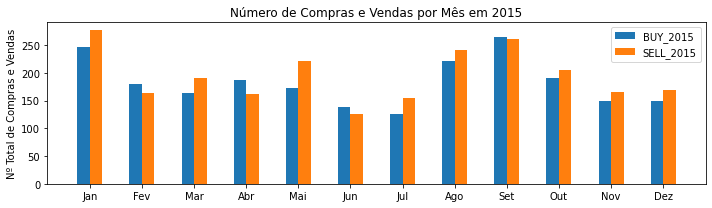

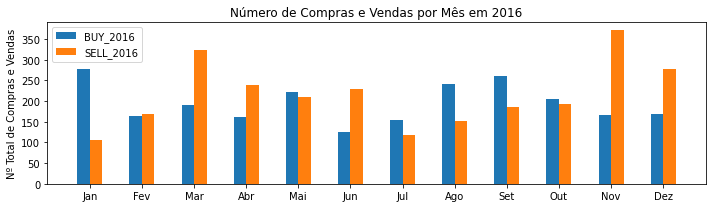

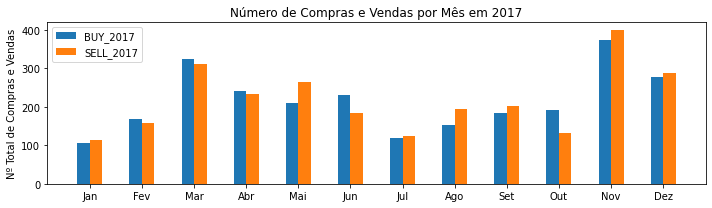

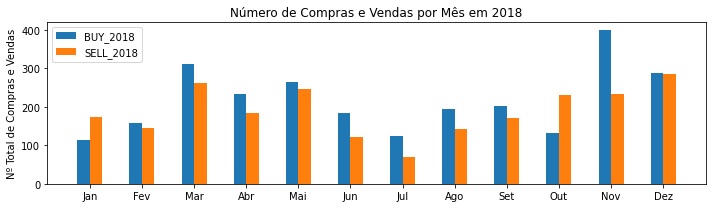

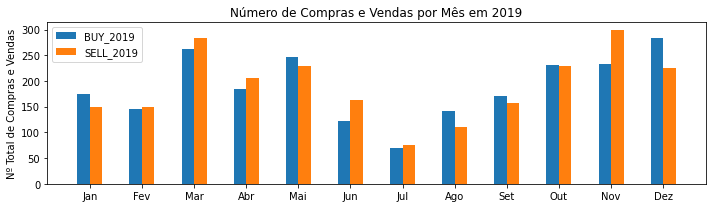

In [58]:
labels = ['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez']
lista = []

for i in range(2015, 2020):
    
    buy  = df[df.DATETIME.dt.year == i].groupby(df.DATETIME.dt.month)['BUY'].sum()
    sell = df[df.DATETIME.dt.year == i].groupby(df.DATETIME.dt.month)['SELL'].sum()
    lista.append(buy)
    lista.append(sell)

x = np.arange(len(labels))  # the label locations
width = 0.24  # the width of the bars

for ano in range(int(len(lista) / 2)):
    aux = ano + 2015
    fig, ax = plt.subplots()
    ax.bar(x - 1*width/2, lista[ano]    , width, label='BUY_{}'.format(aux))
    ax.bar(x + 1*width/2, lista[ano + 1], width, label='SELL_{}'.format(aux))
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Nº Total de Compras e Vendas')
    ax.set_title('Número de Compras e Vendas por Mês em {}'.format(aux))
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
    fig.tight_layout()
    plt.rcParams['figure.figsize'] = (10,3)
    plt.show()

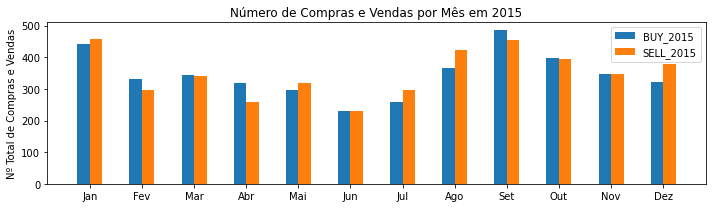

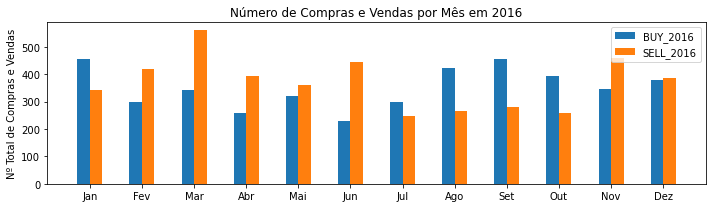

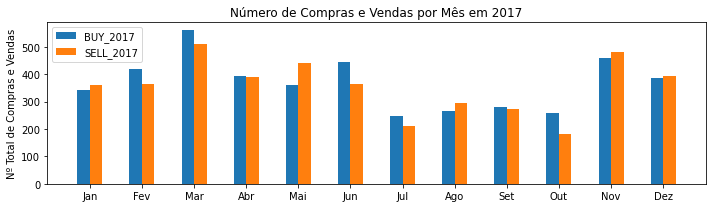

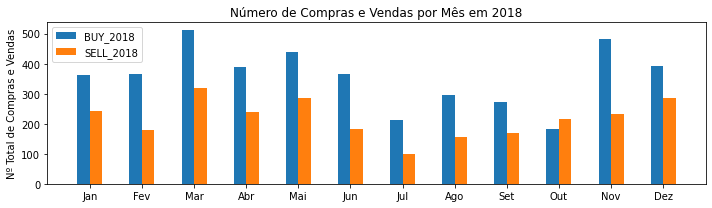

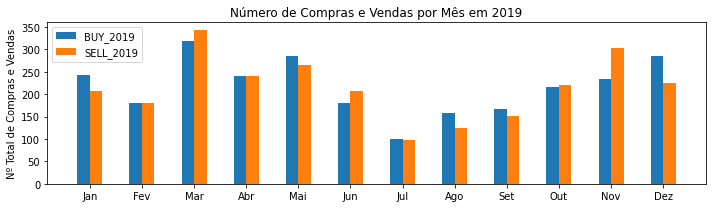

In [42]:
labels = ['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez']
lista = []

for i in range(2015, 2020):
    
    buy  = df[(df.DATETIME.dt.year == i) & (df.TARGET_PERCENTAGE == 'BUY')].groupby(df.DATETIME.dt.month)['TARGET_PERCENTAGE'].count()
    sell = df[(df.DATETIME.dt.year == i) & (df.TARGET_PERCENTAGE == 'SELL')].groupby(df.DATETIME.dt.month)['TARGET_PERCENTAGE'].count()
    lista.append(buy)
    lista.append(sell)

x = np.arange(len(labels))  # the label locations
width = 0.24  # the width of the bars

for ano in range(int(len(lista) / 2)):
    aux = ano + 2015
    fig, ax = plt.subplots()
    ax.bar(x - 1*width/2, lista[ano]    , width, label='BUY_{}'.format(aux))
    ax.bar(x + 1*width/2, lista[ano + 1], width, label='SELL_{}'.format(aux))
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Nº Total de Compras e Vendas')
    ax.set_title('Número de Compras e Vendas por Mês em {}'.format(aux))
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
    fig.tight_layout()
    plt.rcParams['figure.figsize'] = (10,3)
    plt.show()

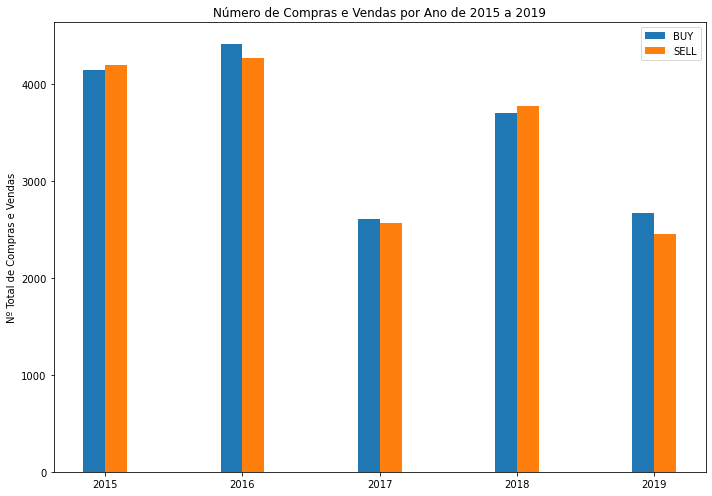

In [61]:
labels = ['2015', '2016', '2017', '2018', '2019']
buy  = df[(df.TARGET_PERCENTAGE == 'BUY')].groupby(df.DATETIME.dt.year)['TARGET_PERCENTAGE'].count()
sell = df[(df.TARGET_PERCENTAGE == 'SELL')].groupby(df.DATETIME.dt.year)['TARGET_PERCENTAGE'].count()

x = np.arange(len(labels))  # the label locations
width = 0.16  # the width of the bars

fig, ax = plt.subplots()

ax.bar(x - 1*width/2, buy[1:6], width, label='BUY')
ax.bar(x + 1*width/2, sell[1:6], width, label='SELL')
# Add some text for labels, title and custom x-axis tick labels, etc.

ax.set_ylabel('Nº Total de Compras e Vendas')
ax.set_title('Número de Compras e Vendas por Ano de 2015 a 2019')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()
plt.rcParams['figure.figsize'] = (10,7)
plt.show()


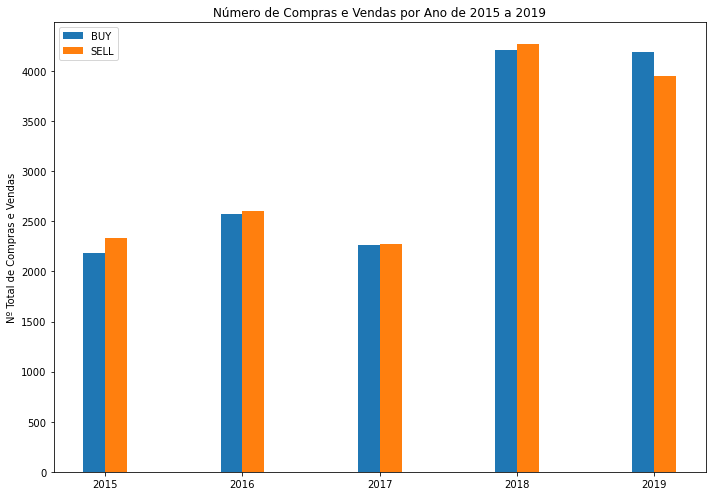

In [63]:
labels = ['2015', '2016', '2017', '2018', '2019']
buy  = df.groupby(df.DATETIME.dt.year)['BUY'].sum().values
sell = df.groupby(df.DATETIME.dt.year)['SELL'].sum().values

x = np.arange(len(labels))  # the label locations
width = 0.16  # the width of the bars

fig, ax = plt.subplots()

ax.bar(x - 1*width/2, buy[1:6], width, label='BUY')
ax.bar(x + 1*width/2, sell[1:6], width, label='SELL')
# Add some text for labels, title and custom x-axis tick labels, etc.

ax.set_ylabel('Nº Total de Compras e Vendas')
ax.set_title('Número de Compras e Vendas por Ano de 2015 a 2019')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()
plt.rcParams['figure.figsize'] = (10,7)
plt.show()


In [45]:
df.query('HORA_NOBRE == 2')

,DATETIME,DATE,TIME,OPEN,HIGH,LOW,CLOSE,VOL,BBANDS_Upper_5,BBANDS_Lower_5,...,HORA_NOBRE,TARGET_WIN,TARGET_WIN_CAT3,TARGET_WIN_CAT3_LABEL,PRICE_PERCENTAGE,TARGET_PERCENTAGE,TARGET_WIN_CAT_ENC,HOLD,SELL,BUY


In [46]:
df.query('TARGET_WIN < -6000')

,DATETIME,DATE,TIME,OPEN,HIGH,LOW,CLOSE,VOL,BBANDS_Upper_5,BBANDS_Lower_5,...,HORA_NOBRE,TARGET_WIN,TARGET_WIN_CAT3,TARGET_WIN_CAT3_LABEL,PRICE_PERCENTAGE,TARGET_PERCENTAGE,TARGET_WIN_CAT_ENC,HOLD,SELL,BUY
66038,2017-05-17 17:40:00,2017.05.17,17:40:00,68000.0,68040.0,67995.0,68035.0,3798.0,68056.681158,67903.318842,...,2,-6855.0,SELL,2,136.07,SELL,2,0,1,0
66039,2017-05-17 17:45:00,2017.05.17,17:45:00,68040.0,68050.0,67930.0,67930.0,4868.0,68052.597450,67911.402550,...,2,-6750.0,SELL,2,135.86,SELL,2,0,1,0
66040,2017-05-17 17:50:00,2017.05.17,17:50:00,67940.0,68010.0,67930.0,67985.0,5819.0,68054.111847,67919.888153,...,2,-6805.0,SELL,2,135.97,SELL,2,0,1,0


In [47]:
df['HORA_NOBRE']

0         2
1         2
2         2
3         2
4         2
         ..
139876    2
139877    2
139878    2
139879    2
139880    2
Name: HORA_NOBRE, Length: 139881, dtype: object

In [48]:
df.dtypes

DATETIME              datetime64[ns]
DATE                          object
TIME                          object
OPEN                         float64
HIGH                         float64
                           ...      
TARGET_PERCENTAGE             object
TARGET_WIN_CAT_ENC             int64
HOLD                           int64
SELL                           int64
BUY                            int64
Length: 139, dtype: object

In [49]:
#Determine a tabela pivot
impute_grps = df.pivot_table(values=["BUY"], index=["MES","DIA_SEMANA","HORA_NOBRE"], aggfunc=np.sum)
impute_grps

BUY
MES DIA_SEMANA HORA_NOBRE     
1   0          0            11
               1            75
               2           151
    1          0            16
               1            89
...                        ...
12  3          1            87
               2           234
    4          0            18
               1           105
               2           221

[180 rows x 1 columns]

### Esta primeira análise é feita com features categóricas de buy e sell de +/- 150 pontos e horizonte de previsão de 3 candles de 5min. 

### Para uma próxima análise fazer para:  
#### +/- 200 pontos
#### variação de +/- 0,2% (100k * 0,2% = 200)